<a href="https://colab.research.google.com/github/AnkeHooliganke/ml-course/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
!wget https://raw.githubusercontent.com/AnkeHooliganke/ml-course/main/week7_nnintro/modules.py

--2021-12-19 15:50:11--  https://raw.githubusercontent.com/AnkeHooliganke/ml-course/main/week7_nnintro/modules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41935 (41K) [text/plain]
Saving to: ‘modules.py’

modules.py          100%[===================>]  40.95K  --.-KB/s    in 0.001s  

2021-12-19 15:50:11 (45.8 MB/s) - ‘modules.py’ saved [41935/41935]



In [ ]:
from modules import *

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

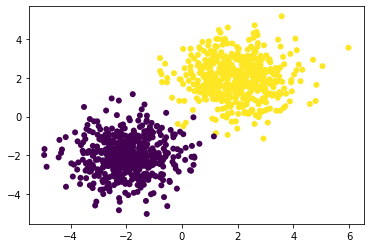

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [ ]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

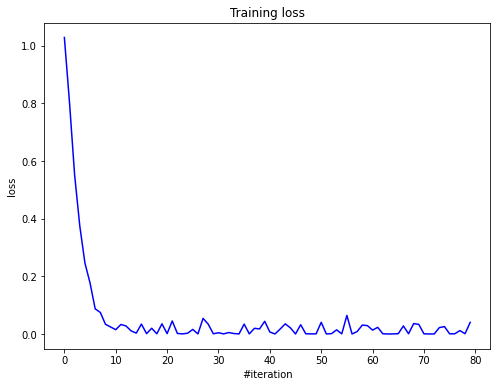

Current loss: 0.040208


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # print(x_batch.shape)

        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        # print(net.getGradParameters())      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
! wget https://raw.githubusercontent.com/AnkeHooliganke/ml-course/main/week7_nnintro/mnist.py

--2021-12-19 15:50:23--  https://raw.githubusercontent.com/AnkeHooliganke/ml-course/main/week7_nnintro/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2021-12-19 15:50:23 (49.9 MB/s) - ‘mnist.py’ saved [2697/2697]



In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
import random

plt.rcParams['figure.figsize'] = (14.0, 12.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


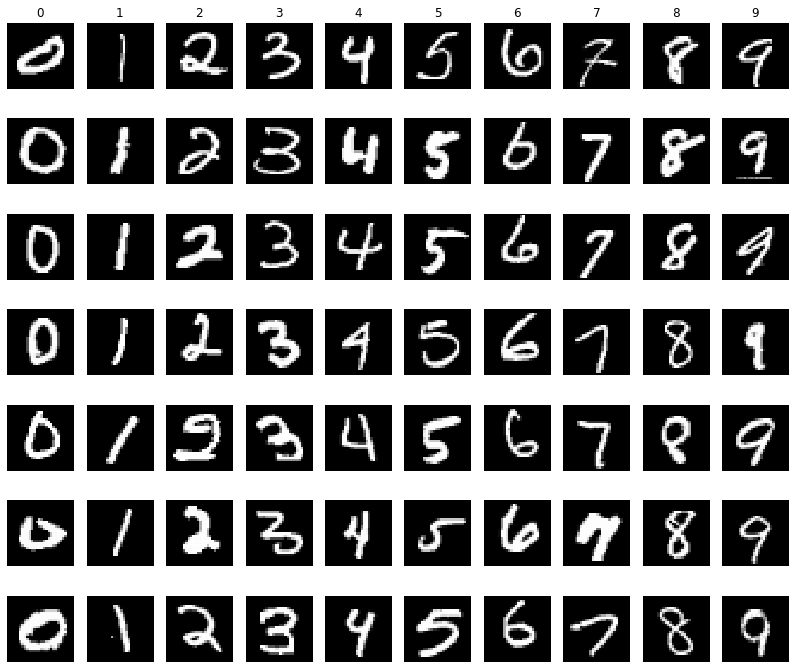

In [ ]:
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

One-hot encode the labels first.

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse=False, dtype=np.int8)
y_train = onehot.fit_transform(y_train.reshape((-1, 1)))
y_val = onehot.transform(y_val.reshape((-1, 1)))
y_test = onehot.transform(y_test.reshape((-1, 1)))

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28), (50000, 10))

In [ ]:
X_batch_mean = np.mean(X_train[:5000, :, :].reshape((5000 * 28 * 28, )), axis=0)  # 0.129
X_batch_var = np.var(X_train[:5000, :, :].reshape((5000 * 28 * 28, )), axis=0)    # 0.093

def normalize(X):
  return (X.reshape((X.shape[0], 28 * 28)) - X_batch_mean) / X_batch_var

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [ ]:
# Aктивации

loss_collection = {"ReLU": [], "ELU": [], "SoftPlus": [], "LeakyReLU":[]}
activation_collection = {"ReLU": ReLU, "ELU": ELU, "SoftPlus": SoftPlus, "LeakyReLU": LeakyReLU}

In [ ]:
def create_net(activation):
  annet = Sequential()
  annet.add(Linear(784, 1668))
  annet.add(activation())
  annet.add(Linear(1668, 256))
  annet.add(activation())
  annet.add(Linear(256, 10))
  annet.add(LogSoftMax())

  return annet


def train_loop(annet, activation_name, opt=sgd_momentum, config={"learning_rate": 0.001, "momentum": 0.9}):
  n_epoch = 4
  batch_size = 1024
  optimizer_state = {}
  loss_history = []

  annet.train()

  loss_function = ClassNLLCriterion()

  for i in range(n_epoch):
    print('epoch ', i)
    for x, y in get_batches((X_train, y_train), batch_size):
        annet.zeroGradParameters()

        pred = annet.forward(x)
        loss = loss_function.forward(pred, y)

        grad = loss_function.backward(pred, y)
        annet.backward(x, grad)
        
        opt(annet.getParameters(), annet.getGradParameters(), config, optimizer_state)

        loss_history.append(loss)

    print('epoch loss ', loss_history[-1])

  loss_collection[activation_name] = loss_history


In [ ]:
for activation_name in activation_collection:
  print(activation_name)

  annet = create_net(activation_collection[activation_name])
  train_loop(annet, activation_name)

  print("loss: ", loss_collection[activation_name][-1])

ReLU
epoch  0
epoch loss  0.8091834889338126
epoch  1
epoch loss  0.49715163325452244
epoch  2
epoch loss  0.39388965102818657
epoch  3
epoch loss  0.36617405918845675
loss:  0.36617405918845675
ELU
epoch  0
epoch loss  0.5869747708394408
epoch  1
epoch loss  0.39484189704831346
epoch  2
epoch loss  0.34411534556753004
epoch  3
epoch loss  0.3234230252007023
loss:  0.3234230252007023
SoftPlus
epoch  0
epoch loss  1.1380984129831941
epoch  1
epoch loss  0.6269022434095193
epoch  2
epoch loss  0.451143887214691
epoch  3
epoch loss  0.40758166086941705
loss:  0.40758166086941705
LeakyReLU
epoch  0
epoch loss  0.7981623097275958
epoch  1
epoch loss  0.4831604106958452
epoch  2
epoch loss  0.377588348249288
epoch  3
epoch loss  0.32719302652367555
loss:  0.32719302652367555


In [ ]:
# посмотрим на BatchNorm + ELU
norm_annet = Sequential()

norm_annet.add(Linear(784, 1668))
norm_annet.add(BatchNormalization(alpha=0.9))
norm_annet.add(ChannelwiseScaling(1668))
norm_annet.add(ELU())

norm_annet.add(Linear(1668, 256))
norm_annet.add(BatchNormalization())
norm_annet.add(ChannelwiseScaling(256))
norm_annet.add(ELU())

norm_annet.add(Linear(256, 10))
norm_annet.add(LogSoftMax())

In [ ]:
loss_collection['BatchNormELU'] = []
train_loop(norm_annet, 'BatchNormELU', config={"learning_rate": 0.1, "momentum": 0.9})  
                                                # lr пришлось повысить, на 0.001 loss совсем не двигался с места
                                                # (без bn понижение lr сходимость не ускоряет, экспериметр чист)

epoch  0
epoch loss  0.37013346851206413
epoch  1
epoch loss  0.37206549344816514
epoch  2
epoch loss  0.25469035846706195
epoch  3
epoch loss  0.29411779770081475


In [ ]:
# вау

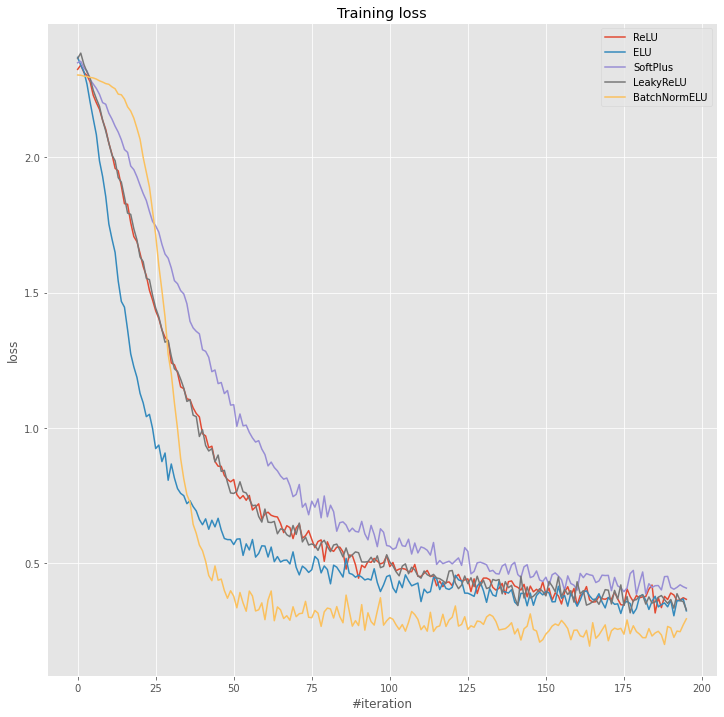

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 12))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
for activation_name in loss_collection:
  plt.plot(loss_collection[activation_name], label=activation_name)

plt.legend()
plt.show()

In [ ]:
# у нас есть победитель!

In [ ]:
# Adam + BatchNorm + ELU:

norm_annet = Sequential()

norm_annet.add(Linear(784, 1668))
norm_annet.add(BatchNormalization(alpha=0.9))
norm_annet.add(ChannelwiseScaling(1668))
norm_annet.add(ELU())

norm_annet.add(Linear(1668, 256))
norm_annet.add(BatchNormalization())
norm_annet.add(ChannelwiseScaling(256))
norm_annet.add(ELU())

norm_annet.add(Linear(256, 10))
norm_annet.add(LogSoftMax())

loss_collection['AdamBatchNormELU'] = []
train_loop(norm_annet, 'AdamBatchNormELU', opt=adam_optimizer, 
           config={"learning_rate": 0.1, "beta1": 0.8, "beta2": 0.99, "epsilon": 1e-3}) 



epoch  0
epoch loss  0.36063952940827815
epoch  1
epoch loss  0.2231956512303902
epoch  2
epoch loss  0.09278848127514763
epoch  3
epoch loss  0.12970234084586346


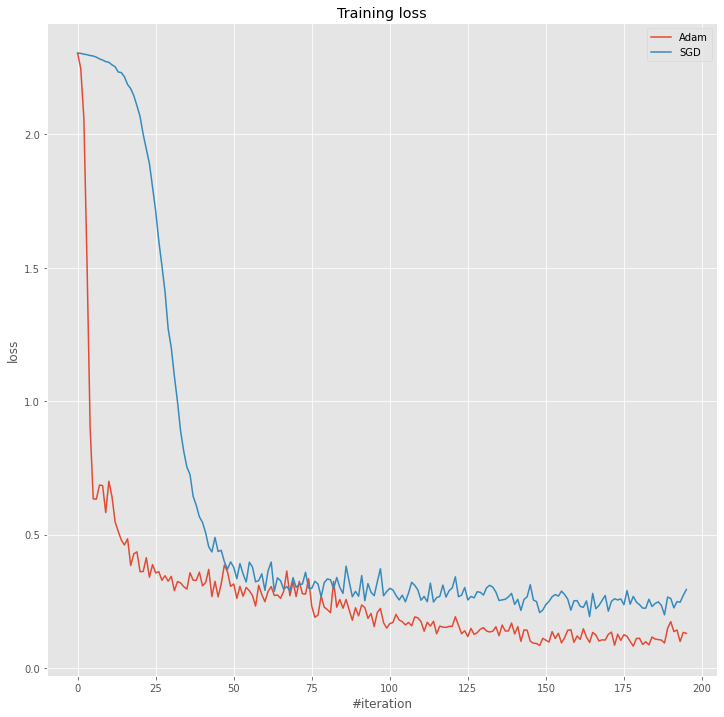

In [ ]:
plt.figure(figsize=(12, 12))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")

plt.plot(loss_collection['AdamBatchNormELU'], label='Adam')
plt.plot(loss_collection['BatchNormELU'], label='SGD')

plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################
# ELU сходится быстрее, ReLU и LeakyReLU почти идентичны, SoftPlus стабильно тормозит. Тем не менее, все сошлись +- к одному результату. 
# Batchnorm улучшает результат, хотя SGD + batchnorm в начале тренировки сходится медленнее, чем без batchnorm, чего не наблюдается с Adam'ом.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################
cool_annet = Sequential()

cool_annet.add(Conv2d(1, 6, 3))
cool_annet.add(ELU())

cool_annet.add(MaxPool2d(2))

cool_annet.add(Flatten())
cool_annet.add(BatchNormalization(alpha=0.9))
cool_annet.add(ChannelwiseScaling(6 * 14 * 14))
cool_annet.add(ELU())

cool_annet.add(Linear(6 * 14 * 14, 12 * 14 * 14,))
cool_annet.add(Dropout(0.3))
cool_annet.add(BatchNormalization())
cool_annet.add(ChannelwiseScaling(12 * 14 * 14))
cool_annet.add(ELU())

cool_annet.add(Linear(12 * 14 * 14, 6 * 14 * 14))
cool_annet.add(ELU())
cool_annet.add(Linear(6 * 14 * 14, 256))
cool_annet.add(ELU())
cool_annet.add(Linear(256, 10))
cool_annet.add(LogSoftMax())


In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, 28, 28))
X_val = X_val.reshape((X_val.shape[0], 1, 28, 28))
X_test = X_test.reshape((X_test.shape[0], 1, 28, 28))

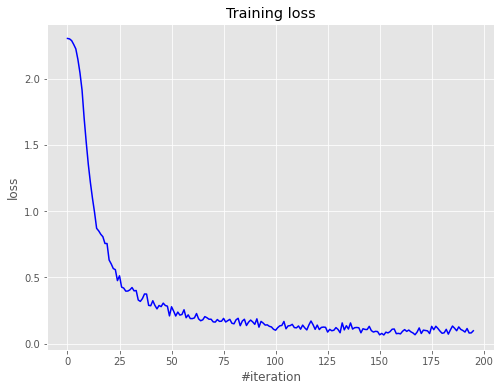

Current loss: 0.096270


In [ ]:
n_epoch = 4
batch_size = 1024

config={"learning_rate": 0.001, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-08}
optimizer_state = {}

loss_history = []
cool_annet.train()

loss_function = ClassNLLCriterion()

for i in range(n_epoch):
  print('epoch ', i)
  for x, y in get_batches((X_train, y_train), batch_size):
      cool_annet.zeroGradParameters()

      pred = cool_annet.forward(x)
      loss = loss_function.forward(pred, y)

      grad = loss_function.backward(pred, y)
      cool_annet.backward(x, grad)
      
      adam_optimizer(cool_annet.getParameters(), cool_annet.getGradParameters(), config, optimizer_state)

      loss_history.append(loss)

      plt.style.use('ggplot')
      display.clear_output(wait=True)
      plt.figure(figsize=(8, 6))
          
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')
      plt.show()
      
      print('Current loss: %f' % loss) 



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
cool_annet.evaluate()

accuracy = 0
batch_size = 10000

i = 0
for x, y in get_batches((X_test, y_test), batch_size):
  i += 1
  pred = cool_annet.forward(x)
  preds = np.argmax(pred, axis=1)
  y_true = np.argmax(y, axis=1)
  accuracy += accuracy_score(preds, y_true)
  

print(accuracy)

0.9658


In [ ]:
accuracy_collection = {i : 0 for i in range(10)}
print('digits accuracy: ')

for i in range(10):
  yi = y_true == i
  predi = preds == i
  accuracy_collection[i] = np.sum(yi * predi) / np.sum(yi)
  print(i, accuracy_collection[i])


digits accuracy: 
0 0.9877551020408163
1 0.9920704845814978
2 0.9709302325581395
3 0.9504950495049505
4 0.9531568228105907
5 0.9674887892376681
6 0.975991649269311
7 0.9503891050583657
8 0.9517453798767967
9 0.9554013875123885


Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################
# 0.9658

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

import warnings
warnings.filterwarnings("ignore")


In [ ]:
dataset_train = torchvision.datasets.MNIST(root='', download=True, transform=ToTensor())
dataset_test = torchvision.datasets.MNIST(root='', train=False, download=True, transform=ToTensor())

In [ ]:
X_train, X_test, y_train, y_test = dataset_train.data, dataset_test.data, dataset_train.targets, dataset_test.targets

In [ ]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
num_test = X_test.shape[0]

Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=1024, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1024)

In [ ]:
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

In [ ]:
mean, std

(tensor(0.1298), tensor(0.3071))

In [ ]:
dataset_train = torchvision.datasets.MNIST(root='', download=False, transform=Compose([ToTensor(), Normalize(mean, std)]))
dataset_test = torchvision.datasets.MNIST(root='', train=False, download=False, transform=Compose([ToTensor(), Normalize(mean, std)]))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=1024, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1024)

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1, 1)
        self.bnorm1 = nn.BatchNorm1d(6 * 14 * 14)

        self.lin1 = nn.Linear(6 * 14 * 14, 12 * 14 * 14)
        self.dropout1 = nn.Dropout(0.3)
        self.bnorm2 = nn.BatchNorm1d(12 * 14 * 14)

        self.lin2 = nn.Linear(12 * 14 * 14, 6 * 14 * 14)
        self.lin3 = nn.Linear(6 * 14 * 14, 256)
        self.lin4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.elu(x)

        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = self.bnorm1(x)
        x = F.elu(x)

        x = self.lin1(x)
        x = self.dropout1(x)
        x = F.elu(x)

        x = self.bnorm2(x)
        x = F.elu(x)
        x = self.lin2(x)
        x = F.elu(x)
        x = self.lin3(x)
        x = F.elu(x)
        x = self.lin4(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net().to(device)

In [ ]:
n_epoch = 4

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_history = []

for i in range(n_epoch):
  net.train()
  for batch, labels in train_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()

    pred = net.forward(batch)

    loss = loss_fun(pred, labels)
    loss.backward()

    optimizer.step()

    loss_history.append(loss)


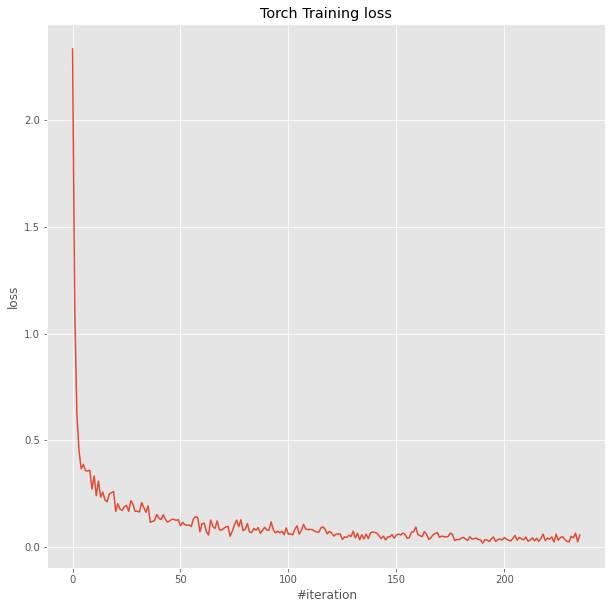

In [ ]:
plt.figure(figsize=(10, 10))
    
plt.title("Torch Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")

plt.plot(loss_history)

plt.show()

In [ ]:
print(loss_history[-1]) 

tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
accs = torch.zeros(10)
digit_shot = {i: 0 for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
  i = 0
  for batch, labels in test_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    preds = net(batch)
    label_preds = preds.argmax(dim=1)
    accuracy = (label_preds == labels).sum() / labels.shape[0]
    accs[i] = accuracy
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    for j in range(len(labels)):
      if labels[j] == label_preds[j]:
        digit_shot[labels[j]] += 1
      digits_cnt[labels[j]] += 1
    i += 1

print("mean accuracy: ", accs.mean())
for i in range(10):
  print("{} accuracy: {}".format(i, digit_shot[i] / digits_cnt[i]))

mean accuracy:  tensor(0.9778)
0 accuracy: 0.9897959183673469
1 accuracy: 0.9938325991189427
2 accuracy: 0.9738372093023255
3 accuracy: 0.9722772277227723
4 accuracy: 0.984725050916497
5 accuracy: 0.9899103139013453
6 accuracy: 0.964509394572025
7 accuracy: 0.9640077821011673
8 accuracy: 0.973305954825462
9 accuracy: 0.9732408325074331
